## Generate data with transient dynamic observations where experiment is concluded at steady state observation

In [1]:
from data.budworm import budworm_ode, simulate_trials
from scipy.integrate import solve_ivp
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('ggplot')
from tqdm.auto import tqdm
savefigs = False

## Create smooth control function

In [2]:
from sympy import symbols, Eq, solve, simplify

r, k = symbols('r k', positive=True)
a = r/k
b = -r
c = (k+r)/k
d = -r
p = (3*a*c-b**2) / (3*a**2)
q = (2*b**3 - 9*a*b*c+27*a**2*d) / (27*a**3)

D = - (4*p**3 + 27*q**2)
D = simplify(D)


D_fixed = D.subs(r, 0.56)
r1, r2 = solve(Eq(D_fixed, 0), k)
print(r1,r2)

k1 = r1-1.1
k2 = r2+1.1

def smooth_k(t):
    A = (k2-k1)/2
    return A*np.sin(t-np.pi/2)+A + k1

6.44569072482332 9.93441120446710


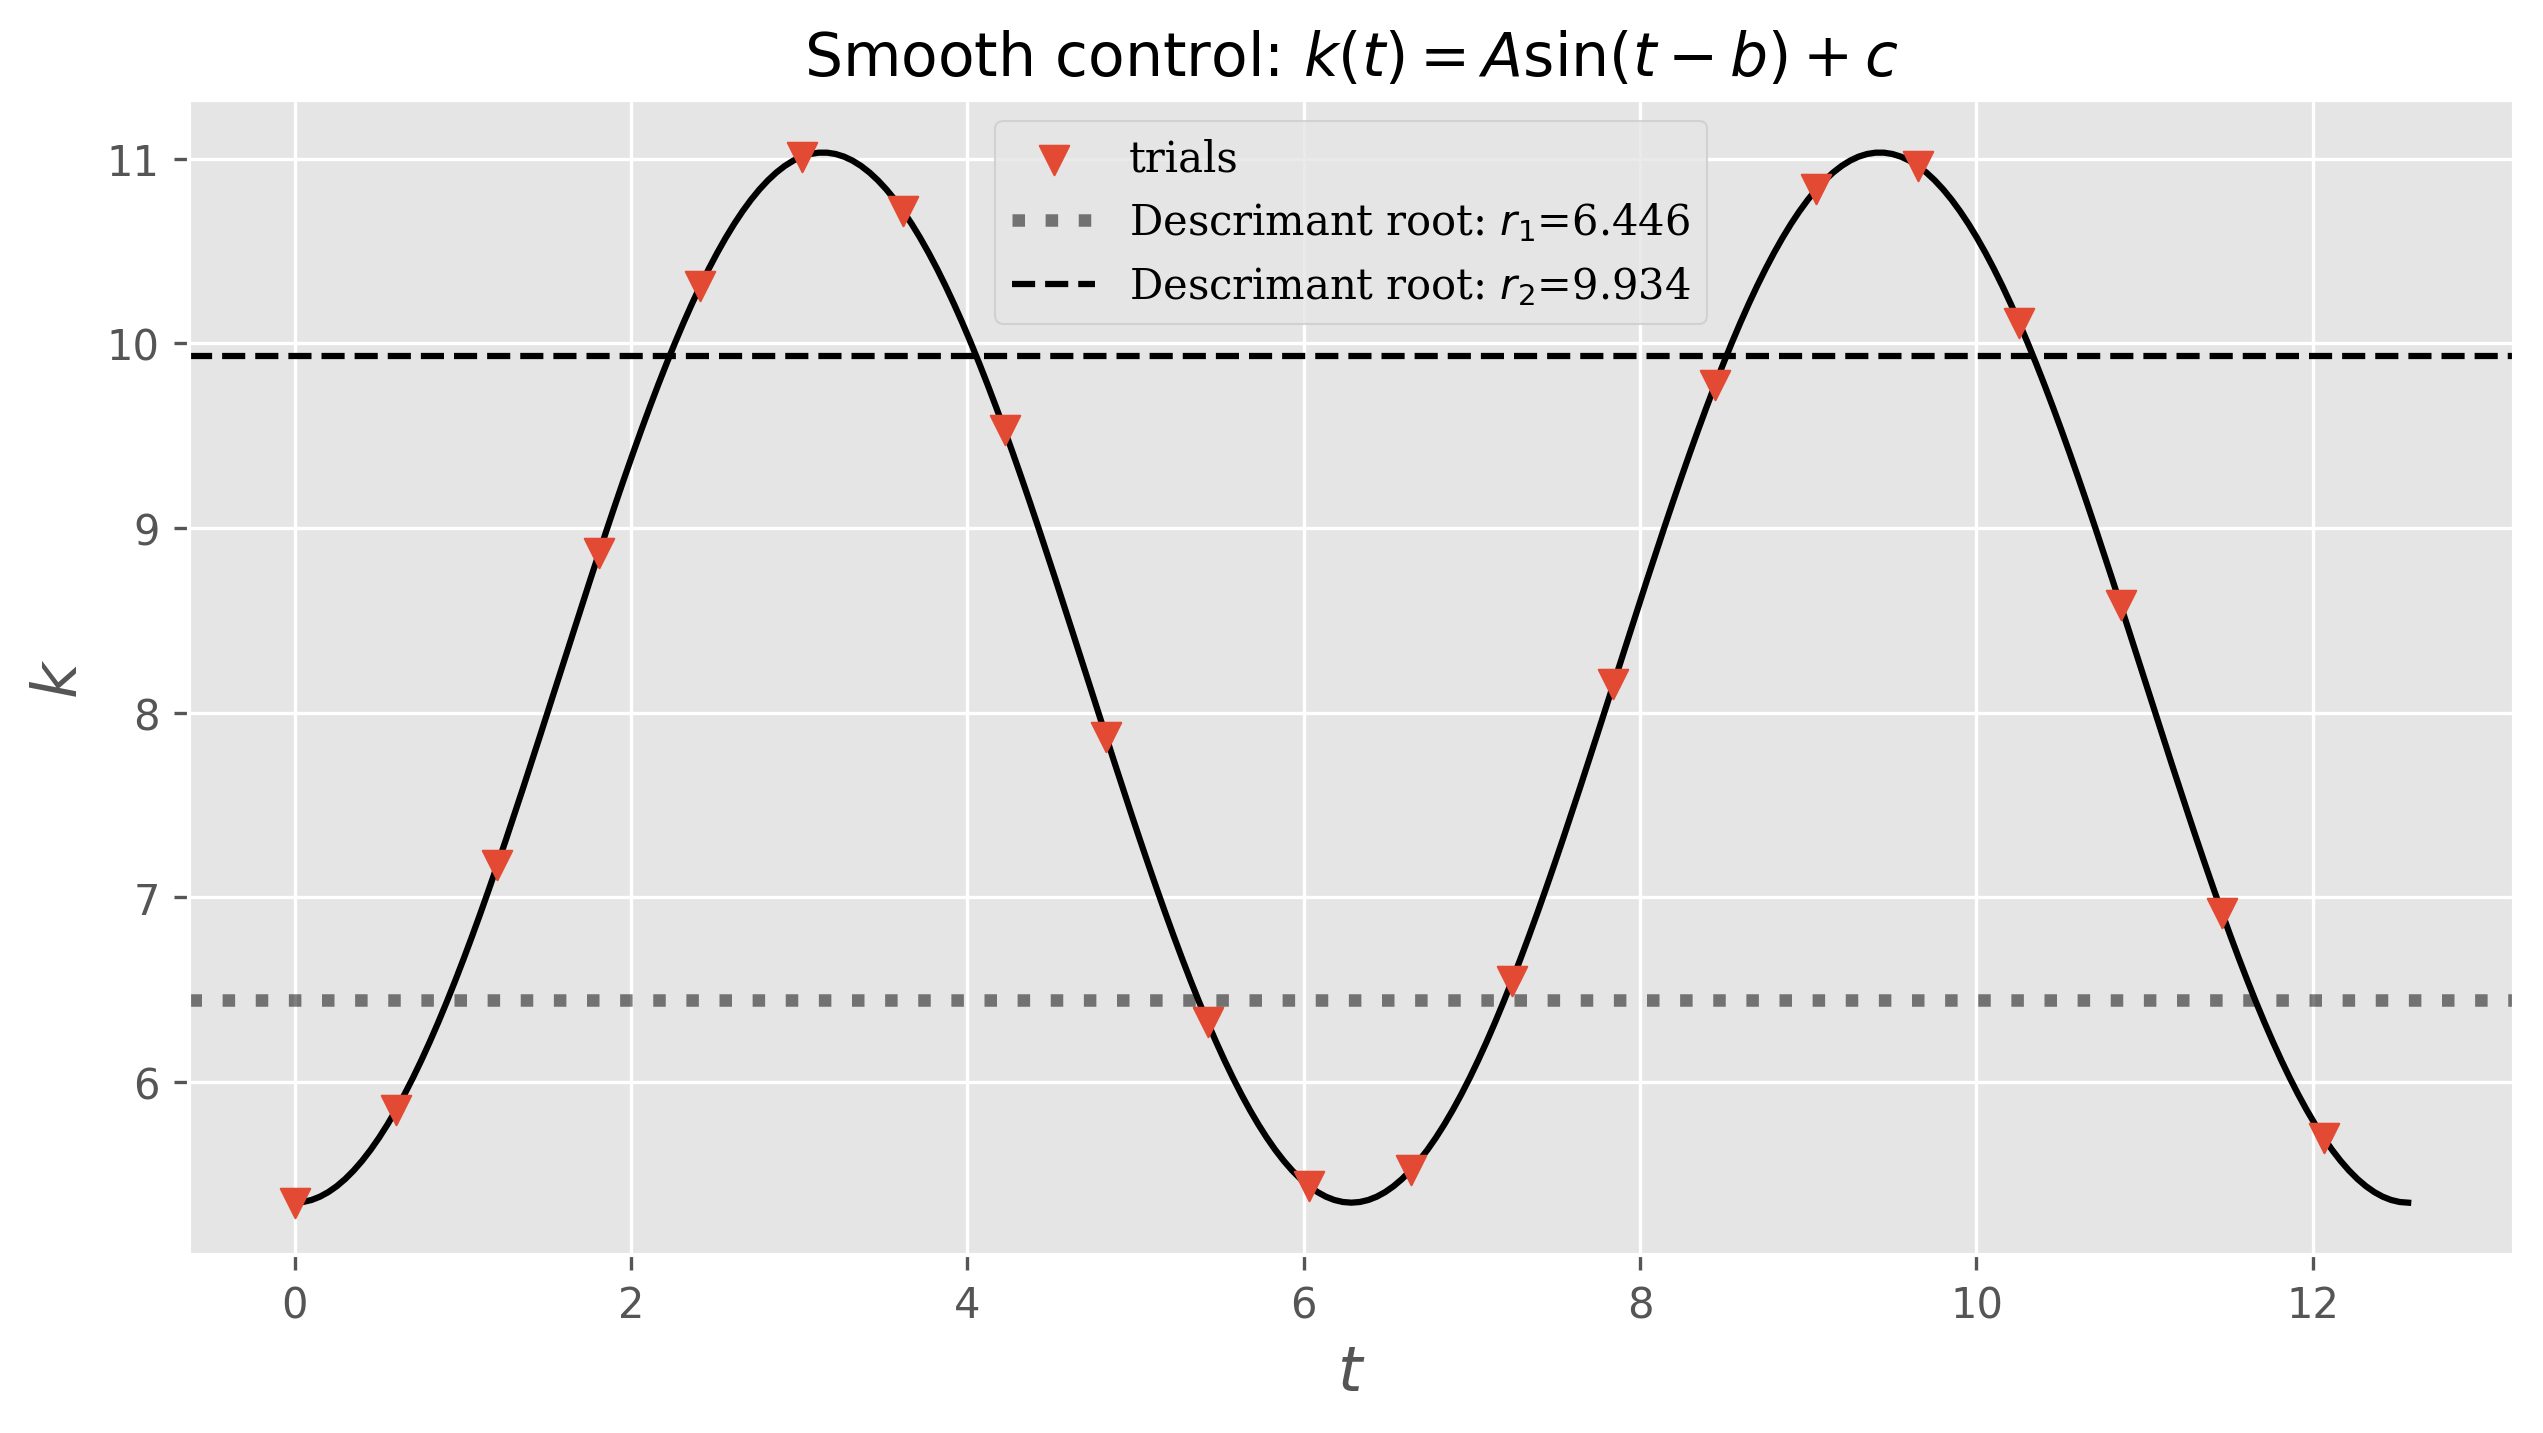

In [3]:
sample_rate = 12
t_span = np.linspace(0,4*np.pi,251)
t_trials = t_span[::sample_rate]
k_true = smooth_k(t_span)
k_trials = smooth_k(t_trials)


fig, ax = plt.subplots(1,1,figsize=(10,5),dpi=300)
t_span = np.linspace(0,4*np.pi,251)

ax.plot(t_span, k_true,c='black',zorder=1)
ax.scatter(
    t_span[::sample_rate],
    k_trials,
    label='trials',
    marker='v',
    s=50,
    zorder=2
)
ax.grid(True)
ax.axhline(r1,linestyle=':',c='black', alpha=0.5,label=rf"Descrimant root: $r_1$={r1:.3f}",lw=3)
ax.axhline(r2, linestyle='--',c='black', label=rf"Descrimant root: $r_2$={r2:.3f}")
ax.set_ylabel(r"$k$", size=15)
ax.set_xlabel(r"$t$",size=15)
ax.set_title(r"Smooth control: $k(t) = A\sin(t-b)+c$")
ax.legend(prop={'family':'serif'})
if savefigs:
    plt.savefig(f"figures/budworm_smooth_control_{len(k_trials)}_trials.pdf")
plt.show()

## Generate trials with control values given above

In [4]:
bw_trials = simulate_trials(
    ks=k_trials,
    x0=1,
    dt=0.2,
    r=0.56,
    eps=1e-4,
    buffer=1e-1,
    t_max=400,
    n_points=701,
    show_progress=True
)
bw_trials

  0%|          | 0/21 [00:00<?, ?it/s]

BudwormTrials contents:
  x_vals: (len=21)
  t_vals: (len=21)
  k_vals: (len=21)
  x_stars: (len=21)
  t_stars: (len=21)
  indices: (len=21)
  dt: 0.2

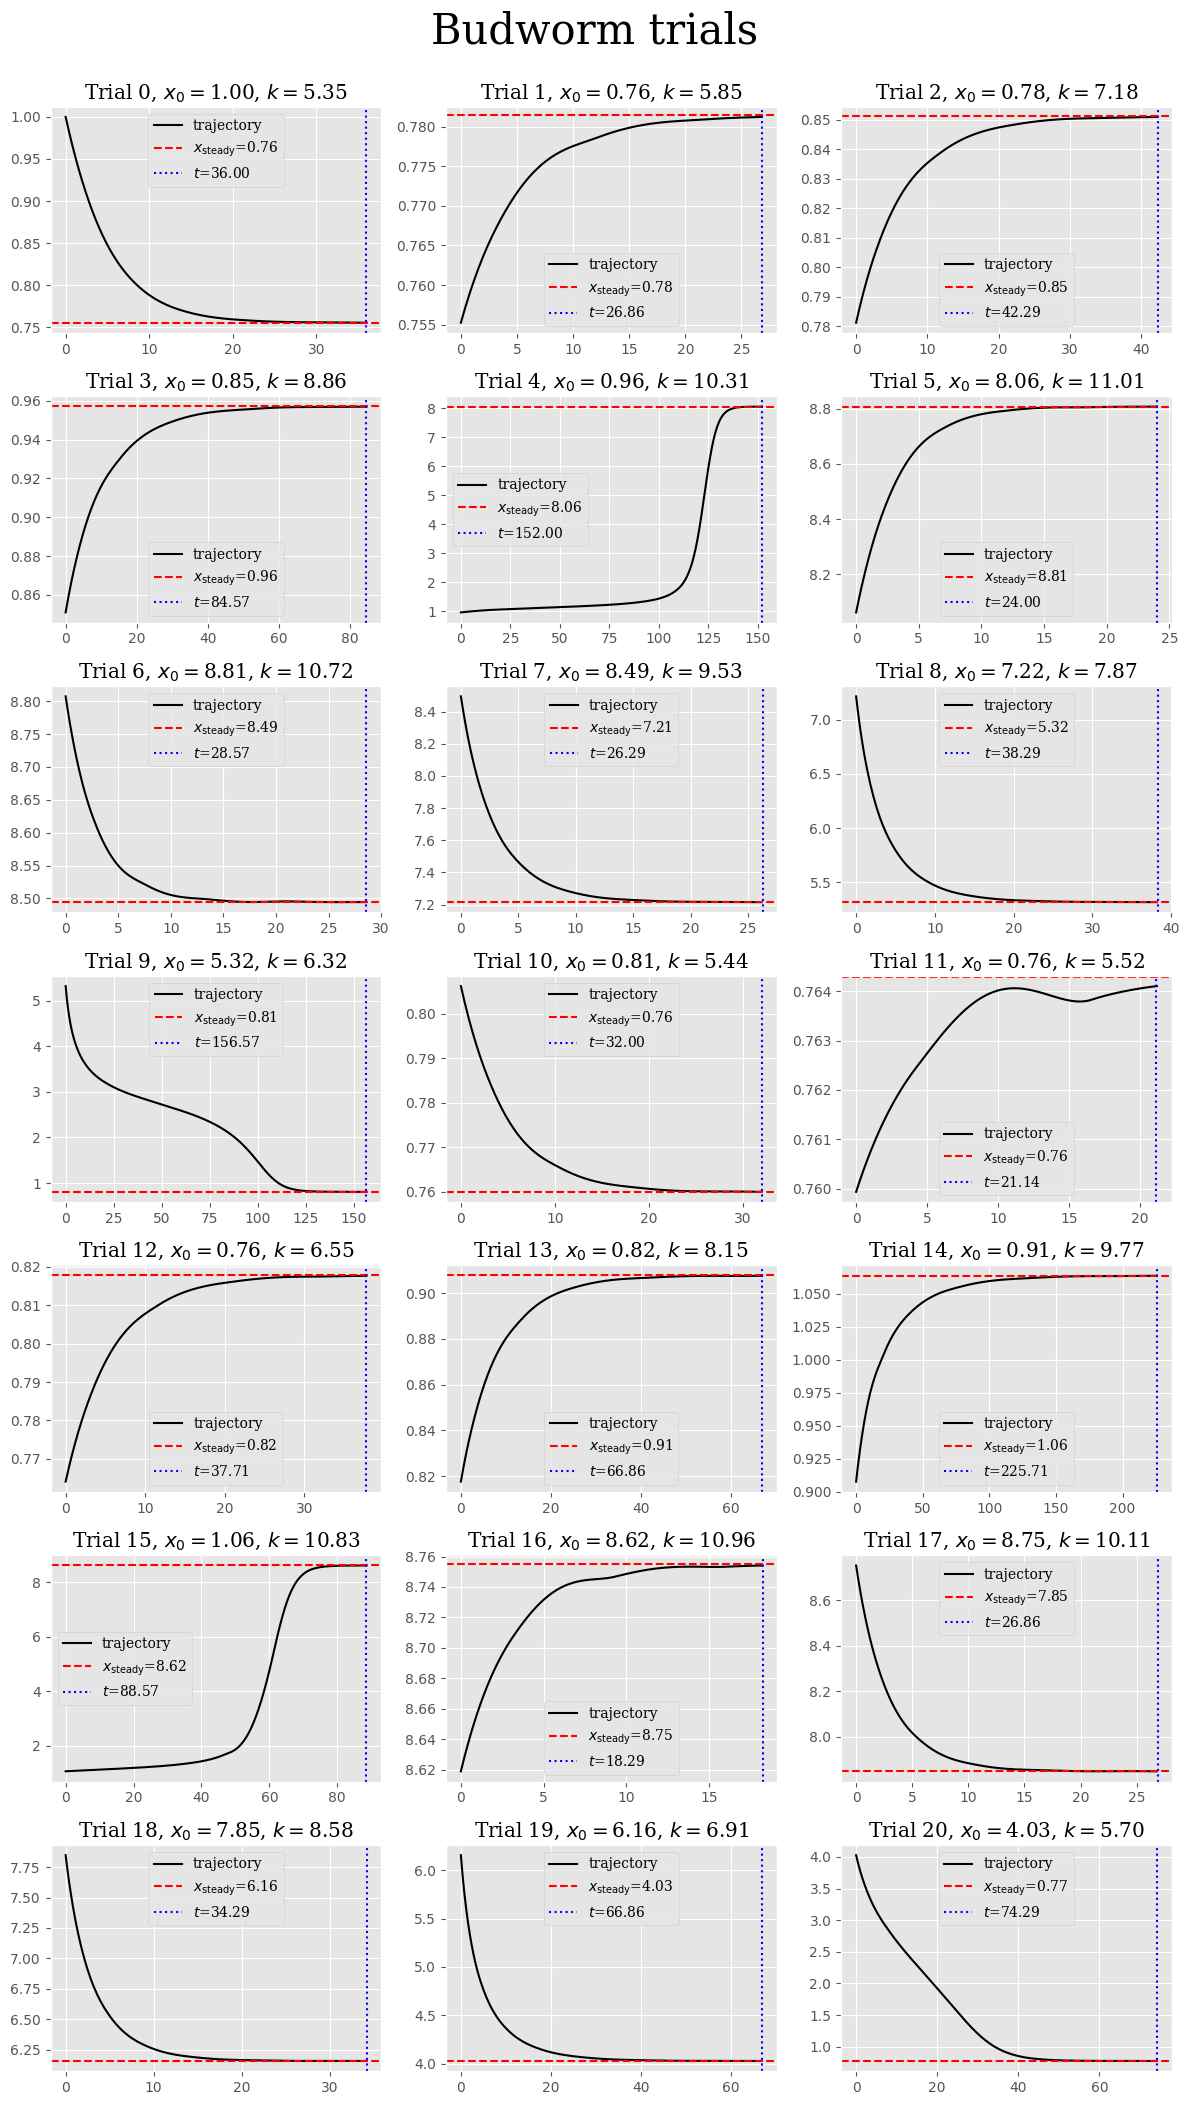

In [5]:
precision = 2
n_plots = len(bw_trials.x_stars)
cols = 3
rows = int(np.ceil(n_plots/cols))

fig, axs = plt.subplots(rows, cols, figsize = (cols*4,rows*3))
axs = axs.flatten()
for idx in range(n_plots):
    x = bw_trials.x_vals[idx]
    t = bw_trials.t_vals[idx]
    xs = bw_trials.x_stars[idx]
    ts = bw_trials.t_stars[idx]

    ax = axs[idx]
    ax.plot(t,x,c='black', label='trajectory')
    ax.axhline(xs,linestyle='--',c='red', label=r"$x_{\text{steady}}$"+f"={xs:.{precision}f}")
    ax.axvline(ts, linestyle=':',c='blue', label=r"$t$="+f"{ts:.{precision}f}")
    ax.legend(prop={'family':'serif'})
    ax.set_title(f"Trial {idx}, "+rf"$x_0=${x[0]:.{precision}f}, " + rf"$k=${k_trials[idx]:.{precision}f}",family='serif')

for idx in range(n_plots,rows*cols):
    fig.delaxes(axs[idx])
fig.suptitle("Budworm trials",family='serif',size=30,y=1.0)
plt.tight_layout()
if savefigs:
    plt.savefig(f"figures/budworm_{len(k_trials)}_trials.pdf")
plt.show()

## Convert to single timeseries

In [6]:
X = np.concatenate(bw_trials.x_vals)

K = []
for k,x in zip(bw_trials.k_vals,bw_trials.x_vals):
    K.append(np.array([k]*len(x)))

K = np.concatenate(K)

T = np.array([bw_trials.dt*i for i in range(len(X))])

trial_idx = np.cumsum([len(x) for x in bw_trials.x_vals]) -1

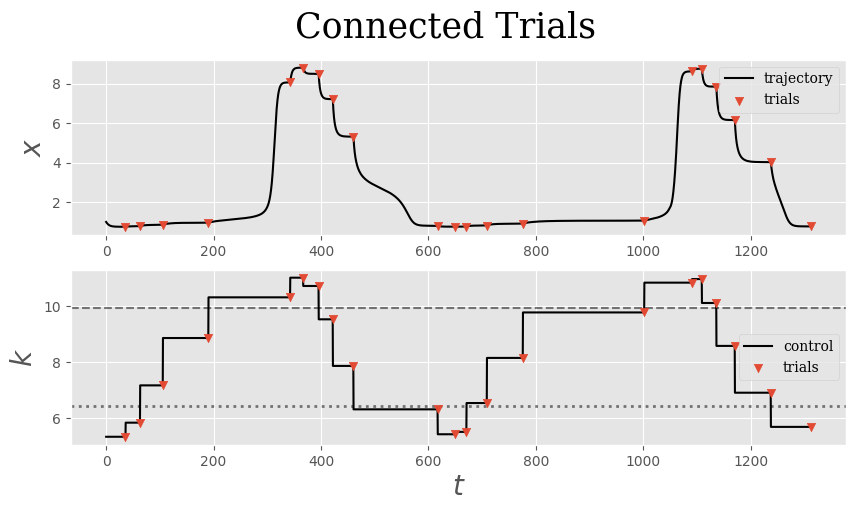

In [7]:
fig, (ax1,ax2) = plt.subplots(2,1,figsize=(10,5))
ax1.plot(T,X,c='black', label='trajectory')
ax1.set_ylabel(r"$x$",size=20)
ax1.scatter(T[trial_idx], X[trial_idx],marker='v', zorder=2,label='trials')
ax1.legend(prop={'family':'serif'})

ax2.plot(T,K,c='black',label='control')
ax2.scatter(T[trial_idx], K[trial_idx],marker='v', zorder=2, label='trials')
ax2.set_ylabel(r"$k$",size=20)
ax2.set_xlabel(r"$t$",size=20,family='serif')

ax2.legend(prop={'family':'serif'})

ax2.axhline(r1,linestyle=':',c='black', alpha=0.5,label=rf"Descrimant root: $r_1$={r1:.3f}",lw=2,zorder=1)
ax2.axhline(r2, linestyle='--',c='black', alpha=0.5,label=rf"Descrimant root: $r_2$={r2:.3f}",zorder=1)



fig.suptitle("Connected Trials", size=25, family='serif')
if savefigs:
    plt.savefig(f"figures/budworm_connected_{len(k_trials)}_trials.pdf")
plt.show()

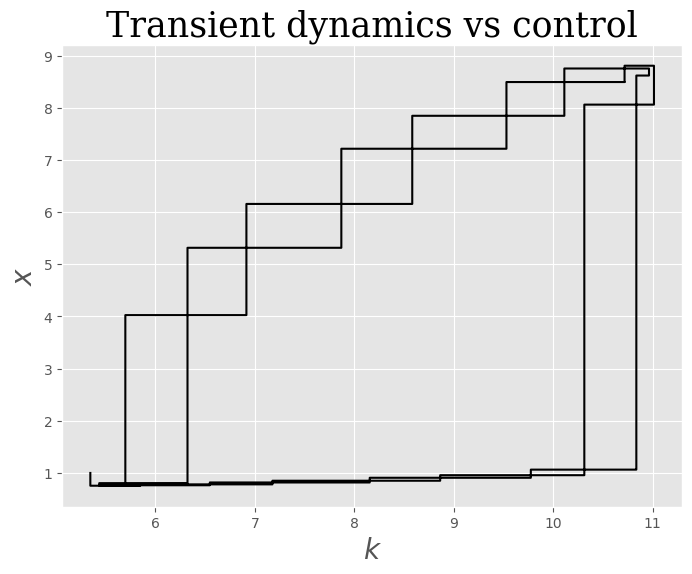

In [8]:
fig,ax = plt.subplots(1,1,figsize=(8,6))
ax.plot(K,X,c='black')
ax.set_xlabel(r"$k$",size=20)
ax.set_ylabel(r"$x$",size=20)
ax.set_title("Transient dynamics vs control", family='serif', size=25)
if savefigs:
    plt.savefig(f"figures/transient_vs_control_{len(k_trials)}_trials.pdf")
plt.show()